/Users/KinjoTasuku/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


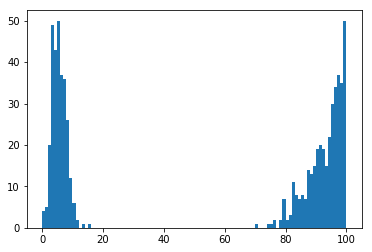

numpy.ndarray

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
from edward.models import (Categorical, Dirichlet, Empirical, Poisson,
                           Mixture, Gamma, ParamMixture, Normal,
                           InverseGamma, MultivariateNormalDiag)

#DATA
N = 1000
_lambda_0 = 5.0
_lambda_1 = 100.0
sess = ed.get_session()

dCat= Categorical([0.1, 0.9])
dPoi_0 = Poisson(_lambda_0)
dPoi_1 = Poisson(_lambda_1)

_x = Mixture(
    cat=dCat,
    components=[dPoi_0, dPoi_1]
)

x_data = sess.run(_x.sample(N))

plt.hist(x_data, bins=100, range=(0, 100))
plt.show()

display(type(x_data))
sess.close()
tf.flags.DEFINE_string('f', '', 'kernel')

In [2]:
from IPython.display import clear_output

K = 2
D = 2

# with tf.Graph().as_default():
sess = ed.get_session()
FLAGS = tf.flags.FLAGS

# MODEL
# すべてのカテゴリが等しい 
pi = Dirichlet(tf.ones(K))
alpha = Gamma(
    concentration=1. * 40.,
    rate=1. * 2.,
    sample_shape=K
)

x = ParamMixture(
    pi,
    {
        'rate': alpha,
    },
    Poisson,
    name="x",
    sample_shape=N
)
cat = x.cat

T = 100

# INFERENCE
qpi = Empirical(
    tf.get_variable(
        "qpi/params", [T, K],
        initializer=tf.constant_initializer(1.0 / K)
    )
)
qalpha = Empirical(tf.get_variable(
    "qalpha/params", [T, K],
    initializer=tf.ones_initializer())
)
qcat = Empirical(
    tf.get_variable(
        "qcat/params", [T, N],
        initializer=tf.zeros_initializer(),
        dtype=tf.int32
    )
)

inference = ed.Gibbs(
    {
        pi: qpi,
        alpha: qalpha,
        cat: qcat,
    },
    data={
        x: x_data
    }
)

inference.initialize()

tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qalpha.params[:t_ph], 0)
display(inference.n_iter)
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        print(sess.run(running_cluster_means, {t_ph: t - 1}))
inference.finalize()


/Users/KinjoTasuku/anaconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


100

  1/100 [  1%]                                ETA: 31s | Acceptance Rate: nan
Inferred cluster means:
[nan nan]
  2/100 [  2%]                                ETA: 17s | Acceptance Rate: 1.000
Inferred cluster means:
[71.93966  45.872208]

Inferred cluster means:
[85.61249  25.633583]
  4/100 [  4%] █                              ETA: 8s | Acceptance Rate: 1.000 
Inferred cluster means:
[90.26873  18.803041]

Inferred cluster means:
[92.54188  15.402944]
  6/100 [  6%] █                              ETA: 5s | Acceptance Rate: 1.000
Inferred cluster means:
[93.94255  13.418149]
  7/100 [  7%] ██                             ETA: 5s | Acceptance Rate: 1.000
Inferred cluster means:
[94.912285 12.057895]

Inferred cluster means:
[95.545395 11.105055]
  9/100 [  9%] ██                             ETA: 4s | Acceptance Rate: 1.000
Inferred cluster means:
[96.02003  10.372918]

Inferred cluster means:
[96.44102   9.796836]
 11/100 [ 11%] ███                            ETA: 3s | Acceptance Rate: 

 86/100 [ 86%] █████████████████████████      ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.24207  5.75973]

Inferred cluster means:
[99.24859    5.7515216]
 88/100 [ 88%] ██████████████████████████     ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.25031   5.748357]

Inferred cluster means:
[99.25921   5.741786]
 90/100 [ 90%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.26468   5.738993]

Inferred cluster means:
[99.27081  5.73404]
 92/100 [ 92%] ███████████████████████████    ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.27864   5.731316]

Inferred cluster means:
[99.27916    5.7246337]
 94/100 [ 94%] ████████████████████████████   ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.2823     5.7204905]

Inferred cluster means:
[99.28469    5.7173467]
 96/100 [ 96%] ████████████████████████████   ETA: 0s | Acceptance Rate: 1.000
Inferred cluster means:
[99.28623  5.71152]

Inferred clu

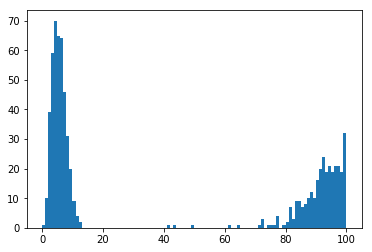

In [3]:
#DATA
N = 1000

_lambda = qpi.sample(N)

_lambda = qalpha.sample(N)
_lambda_0 = _lambda[:, 0]
_lambda_1 = _lambda[:, 1]
sess = ed.get_session()

dCat= Categorical(qpi.sample(N))
dPoi_0 = Poisson(_lambda_0)
dPoi_1 = Poisson(_lambda_1)

x_post = Mixture(
    cat=dCat,
    components=[dPoi_0, dPoi_1]
)

xp_data = sess.run(x_post)

plt.hist(xp_data, bins=100, range=(0, 100))
plt.show()


In [18]:
x_broadcasted = tf.tile(tf.reshape(x_data, [N, 1, 1, 1]), [1, 5, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
log_liks.eval()
# clusters = tf.argmax(log_liks, 1).eval()
# clusters

array([[-3766.6843, -3766.6843],
       [-3897.0007, -3897.0007],
       [-3861.5063, -3861.5063],
       ...,
       [-3787.5005, -3787.5005],
       [-3881.5437, -3881.5437],
       [-3850.8145, -3850.8145]], dtype=float32)

In [32]:
x_post.prob(5.).eval().mean()

0.06869363